In [1]:
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
n_samples = 1000

# create circles

In [3]:
X, y = make_circles(n_samples,noise=.07,random_state=42)

In [4]:
X[:5], y[:5]

(array([[ 0.7301675 ,  0.26189078],
        [-0.71190572,  0.1841244 ],
        [-0.8443255 ,  0.27063595],
        [-0.46454046,  0.65157761],
        [ 0.44899682, -0.89314768]]),
 array([1, 1, 1, 1, 0], dtype=int64))

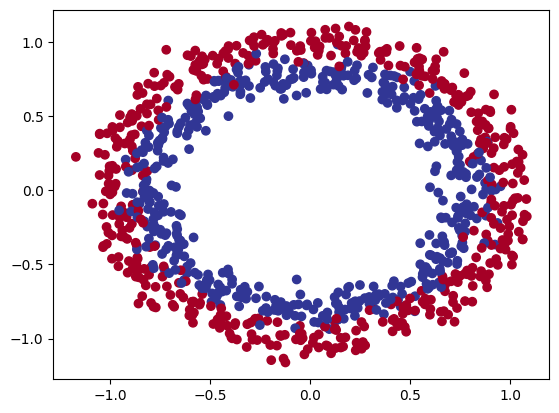

In [5]:
plt.scatter(X[:,0], X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

# turn dataset into Tensors

In [7]:
torch.__version__

'2.4.0+cpu'

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7302,  0.2619],
         [-0.7119,  0.1841],
         [-0.8443,  0.2706],
         [-0.4645,  0.6516],
         [ 0.4490, -0.8931]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# define the classification model from nn.Module

In [13]:
# class CircleModelV1(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_1 = nn.Linear(in_features=2,out_features=5)
#         self.layer_2 = nn.Linear(in_features=5,out_features=1)
#     def forward(self,X):
#         return self.layer_2(self.layer_1(X))

In [14]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layers = nn.Sequential(nn.Linear(in_features=2,out_features=5),
                                                nn.Linear(in_features=5,out_features=1)).to(device)
    def forward(self,X:torch.Tensor) -> torch.Tensor:
        return self.two_linear_layers(X)

In [15]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
    def forward(self,X):
        return self.layer_3(self.layer_2(self.layer_1(X)))

In [16]:
model_circle_v1 = CircleModelV1()

In [17]:
loss_fn = nn.BCEWithLogitsLoss() # expects logits as the input instead of y_pred if the loss func is BCELoss it would expect pred probs
optimizer = torch.optim.SGD(params=model_circle_v1.parameters(),lr=0.01)

In [18]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = correct*100.0/len(y_pred)
    return acc

In [19]:
with torch.inference_mode():
    y_logits = model_circle_v1(X_test).to(device)[:5]
    y_pred_probs = torch.sigmoid(y_logits).squeeze()
    torch.round(y_pred_probs)

In [20]:
y_logits

tensor([[-0.2470],
        [-0.3862],
        [ 0.0838],
        [-0.3646],
        [ 0.0914]])

In [21]:
epochs = 1000

In [22]:
for epoch in range(epochs):
    model_circle_v1.train()
    y_logits = model_circle_v1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # calculate acc/ loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    #optimizer
    optimizer.zero_grad()
    # loss_backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #testing
    model_circle_v1.eval()
    with torch.inference_mode():
        #forward pass
        test_logits = model_circle_v1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate test loss /acc
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss {loss:.5f} acc {acc:.2f} test loss {test_loss:.5f} test acc {test_acc:.2f}")
        

Epoch 0 loss 0.70269 acc 47.86 test loss 0.69372 test acc 51.67
Epoch 10 loss 0.70243 acc 47.86 test loss 0.69363 test acc 52.00
Epoch 20 loss 0.70218 acc 47.86 test loss 0.69355 test acc 52.33
Epoch 30 loss 0.70195 acc 47.86 test loss 0.69348 test acc 52.33
Epoch 40 loss 0.70172 acc 48.00 test loss 0.69341 test acc 52.00
Epoch 50 loss 0.70151 acc 48.00 test loss 0.69335 test acc 52.00
Epoch 60 loss 0.70131 acc 48.00 test loss 0.69330 test acc 51.67
Epoch 70 loss 0.70112 acc 48.29 test loss 0.69325 test acc 51.33
Epoch 80 loss 0.70094 acc 48.29 test loss 0.69320 test acc 51.00
Epoch 90 loss 0.70076 acc 48.43 test loss 0.69316 test acc 51.00
Epoch 100 loss 0.70060 acc 48.00 test loss 0.69312 test acc 50.67
Epoch 110 loss 0.70044 acc 47.57 test loss 0.69309 test acc 50.67
Epoch 120 loss 0.70029 acc 47.43 test loss 0.69306 test acc 51.00
Epoch 130 loss 0.70014 acc 47.86 test loss 0.69303 test acc 51.00
Epoch 140 loss 0.70000 acc 48.43 test loss 0.69300 test acc 51.00
Epoch 150 loss 0.6998

# visualize the predictions 

In [23]:
import requests
from pathlib import Path

In [24]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping the download")
else:
    print("downloading the helper_functions.py ...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping the download


In [25]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [26]:
# import numpy as np
# def plot_decision_boundary(model, X, y):
#     x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
#     y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
#     cmap = plt.cm.Spectral

#     X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
#     y_logits = model_circle_v1(X_test).squeeze()
#     y_pred = torch.round(torch.sigmoid(y_logits)).detach().numpy()
#     # _, y_pred = y_pred.max(dim=1)
#     y_pred = y_pred.reshape(xx.shape)
#     plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())

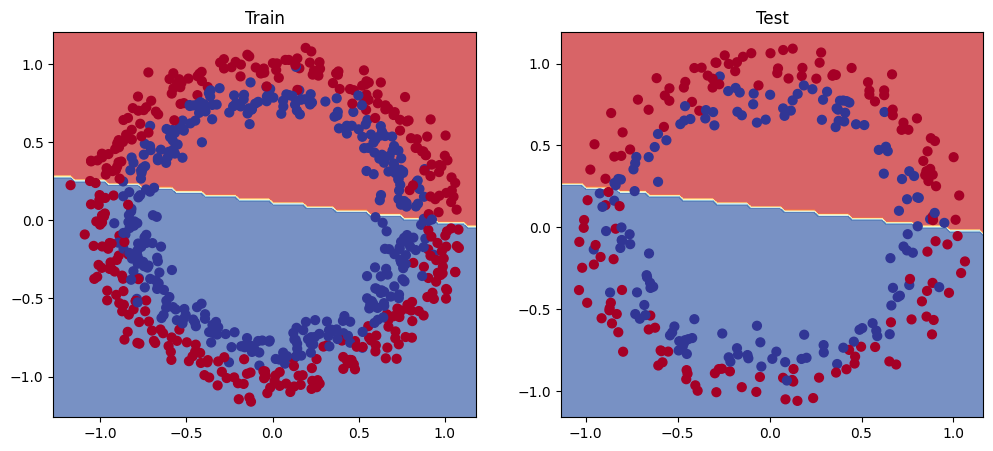

In [27]:
# Visualize the decision boundary
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_circle_v1, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_circle_v1, X=X_test, y=y_test)

In [28]:
model_circle_v1.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.1489,  0.0640],
                      [ 0.2790,  0.4065],
                      [-0.5116, -0.0349],
                      [-0.5835,  0.1973],
                      [ 0.6288, -0.0485]])),
             ('two_linear_layers.0.bias',
              tensor([-1.8088e-01, -4.3277e-01,  2.3574e-01, -4.5875e-04,  5.0997e-01])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.1525, -0.2938,  0.3471, -0.0962,  0.2559]])),
             ('two_linear_layers.1.bias', tensor([-0.2938]))])

In [29]:
model_circle_v2 = CircleModelV2().to(device)
loss_fn = nn.BCEWithLogitsLoss() # expects logits as the input instead of y_pred if the loss func is BCELoss it would expect pred probs
optimizer = torch.optim.SGD(params=model_circle_v2.parameters(),lr=0.01)
model_circle_v2.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6436,  0.6067],
                      [-0.5882,  0.1054],
                      [ 0.3295, -0.6940],
                      [ 0.1701,  0.5397],
                      [ 0.1586, -0.3233],
                      [-0.1268,  0.5584],
                      [-0.3296, -0.2734],
                      [ 0.0906,  0.5394],
                      [-0.0815, -0.6798],
                      [-0.5851,  0.6174]])),
             ('layer_1.bias',
              tensor([ 0.5816, -0.2358, -0.2763,  0.3767, -0.3301,  0.1840,  0.6044,  0.3539,
                       0.5462,  0.4203])),
             ('layer_2.weight',
              tensor([[-9.2211e-02, -1.2076e-01,  1.0728e-01, -3.7827e-02,  2.1511e-01,
                        5.3307e-02,  1.0793e-01,  1.2301e-01, -2.8527e-01, -1.5981e-01],
                      [-1.5213e-01, -2.1966e-01,  1.0477e-01,  1.8308e-01,  1.9974e-01,
                        2.8991e-01,  6.9935e-02,  1.3840e-01,  1.4135e-01, -2.302

In [30]:
for epoch in range(epochs):
    model_circle_v2.train()
    y_logits = model_circle_v2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # calculate acc/ loss
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
    #optimizer
    optimizer.zero_grad()
    # loss_backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #testing
    model_circle_v2.eval()
    with torch.inference_mode():
        #forward pass
        test_logits = model_circle_v2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate test loss /acc
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss {loss:.5f} acc {acc:.2f} test loss {test_loss:.5f} test acc {test_acc:.2f}")

Epoch 0 loss 0.75873 acc 49.14 test loss 0.73865 test acc 52.00
Epoch 10 loss 0.75032 acc 49.14 test loss 0.73172 test acc 52.00
Epoch 20 loss 0.74314 acc 49.14 test loss 0.72588 test acc 52.00
Epoch 30 loss 0.73696 acc 49.14 test loss 0.72094 test acc 52.00
Epoch 40 loss 0.73163 acc 49.14 test loss 0.71674 test acc 52.00
Epoch 50 loss 0.72700 acc 49.14 test loss 0.71317 test acc 52.00
Epoch 60 loss 0.72298 acc 49.14 test loss 0.71013 test acc 52.00
Epoch 70 loss 0.71948 acc 49.14 test loss 0.70753 test acc 52.00
Epoch 80 loss 0.71640 acc 49.14 test loss 0.70530 test acc 52.00
Epoch 90 loss 0.71371 acc 49.14 test loss 0.70340 test acc 52.00
Epoch 100 loss 0.71134 acc 49.14 test loss 0.70177 test acc 52.00
Epoch 110 loss 0.70926 acc 49.14 test loss 0.70037 test acc 52.00
Epoch 120 loss 0.70742 acc 49.14 test loss 0.69918 test acc 52.00
Epoch 130 loss 0.70579 acc 49.14 test loss 0.69816 test acc 52.00
Epoch 140 loss 0.70436 acc 49.14 test loss 0.69730 test acc 52.00
Epoch 150 loss 0.7030

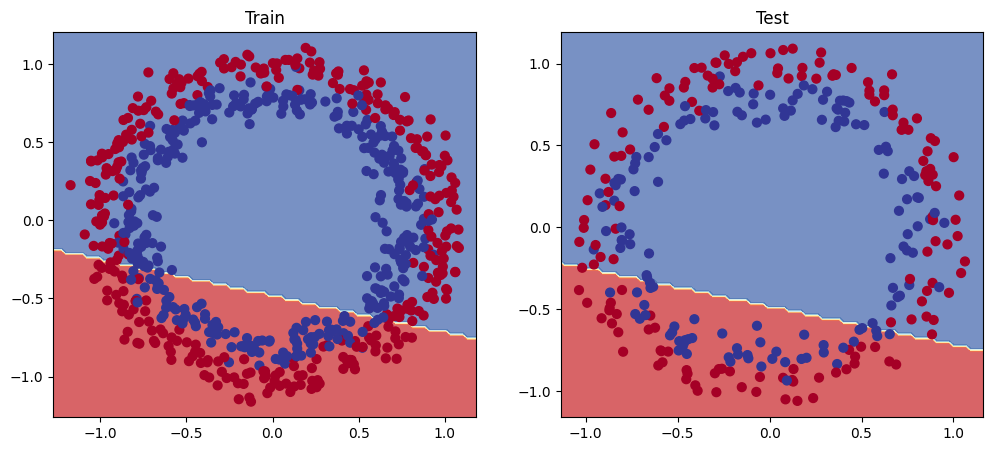

In [31]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_circle_v2, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_circle_v2, X=X_test, y=y_test)